Пришло время сделать свою БД! Подумайте как организовать базу, создайте её и заполните данными через питон на основе своих данных или воспользуйтесь учебными (https://drive.google.com/open?id=1NWIT8Yn-GdgpBUfFO87dnIDQgmE5nj-j)(30 баллов)


Дополнительное задание!
Напарсите данные для своей БД из интернета) Через запросы, конечно)
(10 доп баллов)

In [1]:
import sqlite3 as sq

#### Так как я работаю с клиническими данными, буду использовать набор клинических данных о воспалительных заболеваниях органов мочевыделения. Сам датасет можно найти по ссылке: https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations

Если коротко, то данные имеют следующие фичи, которые идут в столбцах по порядку:

1) Temperature of patient { 35C-42C }

2) Occurrence of nausea { yes, no }

3) Lumbar pain { yes, no }

4) Urine pushing (continuous need for urination) { yes, no }

5) Micturition pains { yes, no }

6) Burning of urethra, itch, swelling of urethra outlet { yes, no }

7) Inflammation of urinary bladder { yes, no }

8) Nephritis of renal pelvis origin { yes, no } 

Подгрузим датасет из папки в виде словаря и в виде списка. В виде словаря им удобно работать в python, но в виде списка эти данные очень хорошо грузятся в SQL, поэтому я делаю тут оба способа. 

In [243]:
data = {'temperature':[],
'nausea': [],
'lumbar_pain' : [],
'urine_pushing' : [],
'micturition_pains' : [],
'burning_of_urethra' : [],
'cystit' : [],
'nephritis' : []  
}

with open('data.txt', 'r') as file:
    for line in file:
        for value, key in enumerate(data.keys()):
            data[key].append(line.split()[value])

Так как данные вносили мои коллеги-медики, как это часто бывает, температура оказалась типом string, да еще и с ',' как десятичным разделителем. Конвертируем данные.

In [244]:
data['temperature'] = list(map(lambda x: float('.'.join(x.split(','))), data['temperature']))

In [245]:
list_data = []
with open('data.txt', 'r') as file:
    for line in file:
        list_data.append([float('.'.join(line.split()[0].split(',')))]+line.split()[1:])

In [246]:
list_data[:5]

[[35.5, 'no', 'yes', 'no', 'no', 'no', 'no', 'no'],
 [35.9, 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'no'],
 [35.9, 'no', 'yes', 'no', 'no', 'no', 'no', 'no'],
 [36.0, 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'no'],
 [36.0, 'no', 'yes', 'no', 'no', 'no', 'no', 'no']]

#### Создадим базу данных

In [247]:
db = sq.connect('acute_inflam.db')

In [248]:
query = '''CREATE TABLE IF NOT EXISTS inflam(
                                inflam_id INTEGER PRIMARY KEY,
                                temperature REAL,
                                nausea TEXT,
                                lumbar_pain TEXT,
                                urine_pushing TEXT,
                                micturition_pains TEXT,
                                burning_of_urethra TEXT,
                                cystit TEXT,
                                nephritis TEXT
)
'''

In [249]:
db.execute(query)

#### Заполним базу данных. Здесь я демонстрирую и способ через цикр и через .executemany()

In [250]:
# iters = len(data['nausea'])

In [251]:
# ins_query = '''
#                 INSERT INTO
#                 inflam(temperature, nausea, lumbar_pain,
#                 urine_pushing, micturition_pains, burning_of_urethra,
#                 cystit, nephritis)
#                 VALUES(?, ?, ?, ?, ?, ?, ?, ?)
# '''
# for i in range(iters):
#     db.executemany(ins_query, tuple(map(lambda x: data[x][i], data.keys())))
# db.commit()

In [252]:
ins_query = '''
                INSERT INTO
                inflam(temperature, nausea, lumbar_pain,
                urine_pushing, micturition_pains, burning_of_urethra,
                cystit, nephritis)
                VALUES(?, ?, ?, ?, ?, ?, ?, ?)
'''
db.executemany(ins_query, list_data)
db.commit()

#### Создадим объект для обращения к нашей базе и сделаем запрос, чтобы проверить, появилась ли она. Положим результат в переменную.

In [253]:
cursor = db.cursor()

In [254]:
nephr = cursor.execute('SELECT inflam_id FROM inflam WHERE nephritis == ?', ('yes',)).fetchall()

In [255]:
nephr = list(map(lambda x: x[0]-1, nephr))

In [256]:
nephr[1]

61

#### Да, все работает, также можно убедиться в этом с помощью DB браузера 
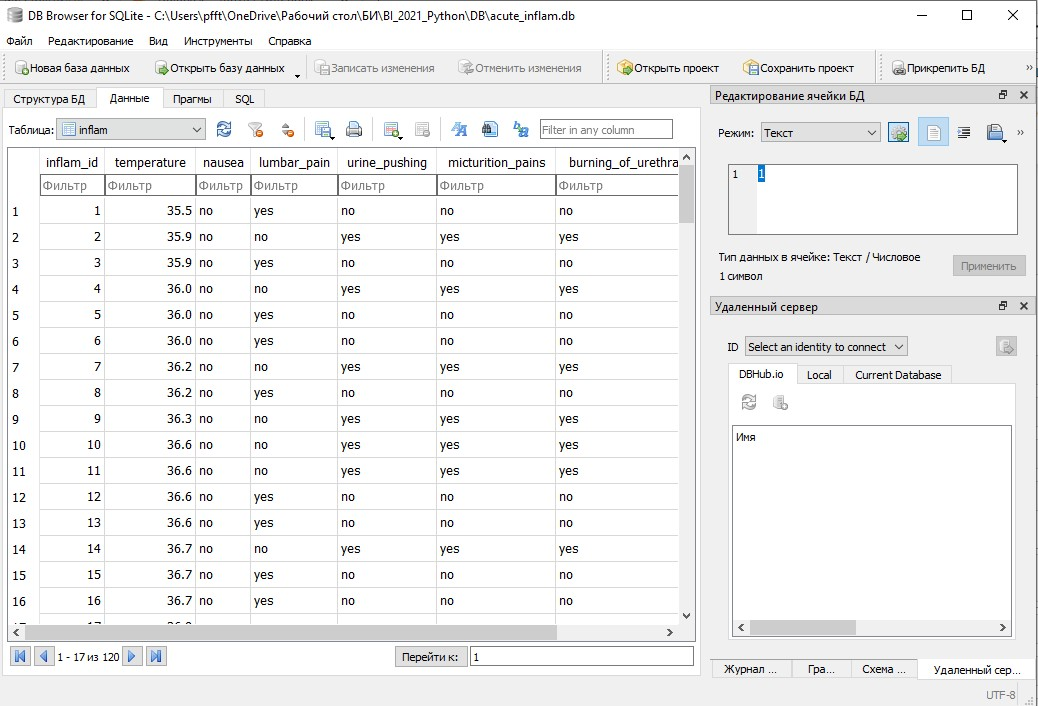

#### Расширим нашу базу. Создадим мини-систему для хранения информации о больных, наподобие БАРС, использующихся в лечебном учреждении. Данных у меня больше нет, поэтому мы их быстро сгенерируем. Заведем в нашей безе данных вторую таблицу для наших пациентов, где будет указан их статус по сахарному диабету, ишемической болезни сердца и артериальной гипертензии - это будет дополнительная страница с социально-значимыми соматическими заболеваниями. Свяжем обе базы по их индексам, это проще всего, т.к. больные одни и те же. Мы сохраняли переменную нефриты, а так как у больных сахарным диабетом это частое состояние, сгенерируем значения для этого признака из нашего запроса. Для артериальной гипертензии и ИБС воспользуемся рандомом.

In [257]:
import numpy as np
SEED = 111
np.random.seed(SEED)

In [258]:
num = len(data['nausea'])

In [259]:
diabet = np.zeros(num)

In [260]:
diabet[np.random.choice(nephr, int(num*0.7))] = 1

In [261]:
ihd = np.zeros(num)
ihd[np.random.choice(range(num), int(num*0.3))] = 1

In [262]:
ag = np.zeros(num)
ag[np.random.choice(range(num), int(num*0.5))] = 1

#### Создаем вторую базу

In [263]:
query_2 = '''CREATE TABLE IF NOT EXISTS somatic(
                                somatic_id INTEGER PRIMARY KEY,
                                diabet INTEGER,
                                coronary_artery_disease INTEGER,
                                arterial_hypertension INTEGER,
                                FOREIGN KEY (somatic_id) REFERENCES inflam (inflam_id)
)
'''

In [264]:
db.execute(query_2)

#### Заполняем ее значениями

In [265]:
ins_query_2 = '''
                INSERT INTO
                somatic(diabet, coronary_artery_disease, arterial_hypertension)
                VALUES(?, ?, ?)
'''
db.executemany(ins_query_2, list(zip(diabet, ihd, ag)))
db.commit()

#### Теперь проверим, как наша вторая база создалась и соединились ли они с первой. Сформируем сложный запрос, посмотрим температуру и поясничную боль у пациентов с диабетом и без.

In [266]:
query_3 = '''SELECT temperature, lumbar_pain FROM inflam
            JOIN somatic ON inflam.inflam_id = somatic.somatic_id
            GROUP BY diabet
'''

In [267]:
cursor.execute(query_3).fetchall()

[(35.5, 'yes'), (38.0, 'yes')]

#### Да, базы объединены. Теперь поменяем какое-нибудь значение.

In [268]:
cursor.execute('UPDATE somatic SET coronary_artery_disease = ? WHERE somatic_id = ?', (1, 50))
db.commit()

#### Выполним проверку.

In [269]:
cursor.execute('SELECT coronary_artery_disease FROM somatic WHERE somatic_id = ?', (50,)).fetchall()

[(1,)]

In [270]:
db.close()